In [165]:
%load_ext autoreload
## Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
## Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [221]:
## Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

### Imports

In [168]:
import sys
coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)

In [169]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState
import importlib

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import hist

from pltStyle import pltStyle
import os
# %matplotlib notebook 

### Parameters of the run

In [170]:
UsingDaskExecutor = False
CERNCondorCluster = False
CoffeaCasaEnv     = False
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True   ### True if run only on one file and five chuncs to debug processor
load_fit_res      = False   ### True if don't repeat the response fits

fine_etabins      = False   ### Don't merge eta bins together when fitting responses. Preprocessing always done in many bins
one_bin           = False   ### Unite all eta and pt bins in one

Nfiles = 100                 ### -1 for all files

tag = '_L5'                 ### L5 or L23, but L23 not supported since ages

### name of the specific run:
# add_tag = '_QCD-JME-etaAut18' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip'
# add_tag='_fine_etaBins'+add_tag
add_tag = '_Herwig-QCD' #-etaAut18'

certificate_dir = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

### Dataset parameters

In [171]:
dataset = 'fileNames/TTToSemi20UL18_JMENano.txt'
dataset = 'fileNames/QCD20UL18_JMENano.txt'
dataset = 'fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'

with open(dataset) as f:
    rootfiles = f.read().split()

### Choose the correct redirector
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
## assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

#### If manyally adding fileslist
# fileslist = ['root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root', #good file
#              'root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root', #bad file
#              'root://grid-dcache.physik.rwth-aachen.de:1094////store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/E6694A4B-483C-BB42-AC66-187B1FE69CCF.root' #bad file2
#             ] 

In [172]:
#Import the correct processor
Processor = importlib.import_module('CoffeaJERCProcessor'+tag).Processor

tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

# if fine_etabins:
#     tag_full='_oneBin'+tag_full

if one_bin:
    tag_full='_oneBin'+tag_full
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if not os.path.exists("fig"):
    os.mkdir("fig/")
    os.mkdir("fig/responses/")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")
    
maxchunks = 5 if test_run else None
if test_run:
    Nfiles = 1

print(f'Runing on dataset {dataset}\n Number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}')


Runing on dataset fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt
 Number of files: 1
 Job with the full tag _L5_Herwig-QCD
 Outname = out/CoffeaJERCOutputs_L5_Herwig-QCD.coffea_test


### For the attempt to correctly combine three ttbar channels. Not fully tested

In [173]:
def find_xsec(key):
    semilepxsec = 0.108*3*0.337*2*2
    dilepxsec = 0.108*3*0.108*3
    hadxsec = 0.337*2*0.337*2

    if "TTToSemi" in key:
        xsec = semilepxsec
    elif "TTToDilep" in key:
        xsec = dilepxsec
    elif "TTToHad" in key:
        xsec = hadxsec
    else:
        xsec = 1
    return xsec

In [174]:
def xsecstr2float(str_input):
    str_split = str_input.split('*')
    try:
        if len(str_split)==1:
            xsec = float(str_split[0])
        elif len(str_split)==2:
            xsec = float(str_split[0])*float(str_split[1])
        else:
            raise ValueError
    except:
        raise ValueError("Check your input files. Cross-secton not correctly defined."+
                         f" It has to be either a number or a number times a factor. Given: {str_input}")
    return xsec

In [223]:
combineTTbar = False

# datasets = ['fileNames/fileNames_TTToSemi20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToDilep20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
#            ]
file_tags = ['Semi', 'Dilep', 'Had']

filesets = {}
if combineTTbar:
    for ftag in file_tags:
        data_name = f'fileNames/fileNames_TTTo{ftag}20UL18_JMENano.txt'
        with open(data_name) as f:
            rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
        fileslist = fileslist[:Nfiles]
        xsec = find_xsec(data_name)
        filesets[ftag] = {"files": fileslist, "metadata": {"xsec": xsec}}
elif "xsecs" in dataset.split('/')[-1]:
    ### if dataset striched together from a set of datasets where the cross-section for each is given in `dataset`
    dataset_path = '/'.join(dataset.split('/')[:-1])
    with open(dataset) as f:
        lines = f.readlines()
    lines_split = [line.split() for line in lines]
    xsec_dict = {lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    file_dict = {lineii[1]: lineii[0] for lineii in lines_split }
    for key in file_dict.keys():
        data_name = file_dict[key]
        with open(dataset_path+'/'+data_name) as f:
            rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
        fileslist = fileslist[:Nfiles]
        filesets[key] = {"files": fileslist, "metadata": {"xsec": xsec_dict[key]}}
    if test_run:
        filesets = {key: filesets[key] for key in list(filesets.keys())[:3]}
        
else:
    fileslist = [xrootdstr + file for file in rootfiles]
    fileslist = fileslist[:Nfiles] # if add_tag=='QCD' else fileslist # :20 to skim the events
    xsec_dict = {'dataset1': 1}
    filesets = {'dataset1': {"files": fileslist, "metadata": {"xsec": 1}}}
# fileslist = fileslist
# if test_run:
#     fileslist = [fileslist[1]]


Test if certificate works to open the file

In [222]:
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = certificate_dir
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [177]:
env_extra = [
            f'export X509_USER_PROXY={certificate_dir}',
            f'export X509_CERT_DIR={certificate_dir}',
        ]

In [178]:
import uproot
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Dask+Condor setup on lxplus
#### 1.) The wrapper needs to be installed following https://github.com/cernops/dask-lxplus
#### 2.) Source lcg environment in bash
#### `source /cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/latest/x86_64-centos7-gcc11-opt/setup.sh`
#### Singularity could work but not confirmed.
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [179]:
 # Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [180]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
 # Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
            env_extra=env_extra,
            cores = 1,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
                'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=200)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
    client.upload_file('count_2d.py')

    client

### Run the processor

In [181]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
chunksize = 10000

if not load_preexisting:
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 2,
#                                               'workers': 2
                                          },
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)

#### Attempt to prevent the error when the cluster closes. Doesn't always work.
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

Loaded histograms from:  out/CoffeaJERCOutputs_L5_Herwig-QCD.coffea_test


In [182]:
# output = util.load('out/CoffeaJERCOutputs_L5_QCD-JME.coffea')
# output_Weights = util.load('out/CoffeaJERCOutputs_L5_QCD-JME-weights.coffea')

In [183]:
# output_Weights = output_Weights['QCD']

### Striching up the sample

In [184]:
def sum_subhist(output, hist_key, allkeys, xsec_dict):
    new_hist = 0
    new_pt_hist = 0
    for sample_key in output.keys():
        response_hist = output[sample_key]['ptresponse'+hist_key]
        pt_hist = output[sample_key]['reco_pt_sumwx'+hist_key]
        hist_sum = response_hist.sum().value
        
        response_hist = response_hist/hist_sum*xsec_dict[sample_key]
        new_hist = new_hist + response_hist
        pt_hist = pt_hist/hist_sum*xsec_dict[sample_key]
        new_pt_hist = new_pt_hist + pt_hist
    return new_hist, new_pt_hist

output_orig = output
if len(xsec_dict.keys()):
    all_samples = [key[10:] for key in output[next(iter(output.keys()))].keys() if 'ptresponse_' in key]
    allkeys = set.union(*[set(output[key]) for key in output.keys()])
    result = {}
    for sample in all_samples:
        new_hist, new_pt_hist = sum_subhist(output, sample, allkeys, xsec_dict)
        result['ptresponse'+sample] = new_hist
        result['reco_pt_sumwx'+sample] = new_pt_hist  
#     result = {key+sample: sum_subhist(output, sample, allkeys) for sample in all_samples for key in ['ptresponse', 'reco_pt_sumwx_']}
    output = result
else:
    try:
        output = output['dataset1']
    except KeyError:
        output=output

### Fit responses

define gaussian function for fitting the responses

In [185]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [186]:
## find the first response histogram to extract the axes
for key in output.keys():
    if 'response' in key:
        response_key = key
        break

if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output[response_key].axes["jeteta"].edges #output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output[response_key].axes["pt_gen"].edges 
#     ptbins = ptbins[2:] #because there is a pt cut on pt gen and no point of fitting and plotting below that
    ptbins_c = output[response_key].axes['pt_gen'].centers
    etabins = np.array([-5.191, -3.489, -3.139, -2.853,   -2.5, -2.322,  -1.93, -1.653, -1.305, -0.783,      0,  0.783,  1.305,  1.653,   1.93,  2.322,    2.5,  2.853,  3.139,  3.489, 5.191])
    etabins = np.array([-5.191, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5.191])

    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

ptresp_edd = output[response_key].axes['ptresponse'].edges
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]

In [187]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

### Testing adding hists

#### To do: update after the change from coffea.hist to hist

In [188]:
# combineTTbar = False
if combineTTbar:
    ids = output[list(output.keys())[0]].axis('dataset').identifiers()
    names = [idii.name for idii in ids  ]

    output_comb = {}

    N = {}
    for s in names:
        N[s] = output['cutflow'][s+': all events']
    N_av = sum(N.values())/3

    for key in output.keys():
        if key!='cutflow':
            hist_comb = output[key].integrate('dataset', ids[0])
            hist_comb.scale(find_xsec(names[0])*N[names[0]]/N_av)
            for ii in range(1,len(ids)-1):
                hist2 = output[key].integrate('dataset', ids[ii])
                hist2.scale(find_xsec(ids[ii].name)*N[names[ii]]/N_av)
                hist_comb = hist_comb+hist2
            output_comb[key] = hist_comb
        else:
            cut_keys = list(output[key].keys())
            len_new_keys = len(cut_keys)//3
            output_comb["cutflow"] = {}
            for cut in range(len_new_keys):
                output_comb["cutflow"]["Inclusive"+cut_keys[cut][4:]] = (output[key][cut_keys[cut]]*find_xsec(names[0])*N[names[0]]/N_av +
                                                               output[key][cut_keys[cut+len_new_keys]]*find_xsec(names[1])*N[names[1]]/N_av +
                                                               output[key][cut_keys[cut+2*len_new_keys]]*find_xsec(names[2])*N[names[2]]/N_av 
                                                              )
                
    output = output_comb
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [189]:
# if combineTTbar:
#     histoMi = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#     histoPl = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#     histo = (histoMi+histoPl)
#     histo.values()[('QCD',)][1:10] 
#     histo.scale(weights[0])
    
#     histo.values()[('QCD',)][1:10] 
    

#     for out, wg in zip(outputs[1:], weights[1:]):
#         histoMi = out['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#         histoPl = out['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#         histo2 = histoMi+histoPl
#         histo2.scale(wg)
#         histo2.values()[('QCD',)][1:10]
#         histo.add(histo2)
        
#     histo.values()[('QCD',)][1:10]

In [190]:
def get_median(xvals, yvals, bin_edges, Neff):
    ''' Calculate median and median error (assuming Gaussian distribution).
    This is the binned median, not the real data median
    Extrapolation withing bins is performed.
    '''
    yvals_cumsum = np.cumsum(yvals)
    N = np.sum(yvals)

    # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
    # so changing limits to match the both cases
    if np.abs(np.sum(yvals)-Neff)/Neff<1e-5:
        N_min_limit=200
    else:
        N_min_limit=50

    if Neff>N_min_limit:
        med_bin = np.nonzero(yvals_cumsum>N/2)[0][0]
        median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
                                                                                 - bin_edges[med_bin])
    else:
        median = 0


    hist_mean = np.sum(xvals*yvals)/sum(yvals) 
    hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
    medianstd = 1.253 * hist_rms/np.sqrt(Neff)
    
    return median, medianstd

In [191]:
def fit_response(xvals, yvals, Neff):
    if_failed = False
    
    # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
    # so changing limits to match the both cases
    if (np.sum(yvals)-Neff)/Neff<1e-5:
        N_min_limit=50
    else:
        N_min_limit=15
    
    nonzero_bins = np.sum(yvals>0)
    if nonzero_bins<2 or Neff<N_min_limit:
        p2=[0,0,0]
        chi2 = np.nan
        cov = np.array([[np.nan]*3]*3)
        Ndof = 0
    #                 print("Too little data points, skipping p = ", p2)
    else:
        try:
            p, cov = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                 ######## Second Gaussian ########
            xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
            xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
            xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
    #                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

            if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
                if len(range(xfit_l,xfit_h))<6:
                    xfit_l = xfit_l-1
                    xfit_h = xfit_h+1
            if xfit_l<0:
                xfit_h-=xfit_l
                xfit_l = 0
            xvals2 = xvals[xfit_l: xfit_h]
            yvals2 = yvals[xfit_l: xfit_h]
    #                     if ptBin.lo>290:
    #                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
    #                         print("yvals = ", yvals)
    #                         print("yvals2 = ", yvals2)
            p2, cov = curve_fit(gauss, xvals2, yvals2, p0=p)
                         ######## End second Gaussian ########

            ygaus = gauss(xvals, *p2)
            chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
            Ndof = len(xvals2)-3
    #                     if chi2<50000:
    #                         pass
    #                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
    #                     else:
    #                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
        except(RuntimeError):   #When fit failed
            p2=[0,0,0]
    #                     print("Fit failed because of non-convergance, p = ", p2)
            chi2 = np.nan
            cov = np.array([[np.nan]*3]*3)
            Ndof = 0
            if_failed = True
            
    return [p2, cov, chi2, Ndof, if_failed]

In [192]:
def plot_response_dist(histo, xvals, p2, cov, chi2, Ndof, median, medianstd, Neff, figName ):
    width_ik = np.abs(p2[2])
    f_xvals = np.linspace(0,max(xvals),5001)
    fgaus2 = gauss(f_xvals, *p2)
    edd = histo.axes['ptresponse'].edges
    histo = histo[1:len(edd)-2] 
    #remove the underflow, overflow. Not sure if in hist.hist it is stored in the last and first bin like in coffea.hist
#     histo = histo[{'ptresponse', blah}]
    
    fig, ax2 = plt.subplots();
#     hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                 fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
    plot = histo.plot1d(ax=ax2, label='dataset', histtype='fill', alpha=0.6)
#     plot[0].set_linewidth(2)
    ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
    ax2.set_xlabel("Response ($p_{T,reco}/p_{T,ptcl}$)")
    ax2.set_xlim(plot_pt_edges[[0,-1]])
    h = ax2.get_ylim()[1]/1.05
    plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(cov[1,1])))
    plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(cov[2,2])))
    plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
    plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
    plt.text(0.03,0.66*h,r'Neff = {0:0.3g}'.format(Neff))
    ax2.legend();

    
    plt.savefig(figName+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
    plt.savefig(figName+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#     print("Saving to: ", figName+'.png')
#     plt.close();   

In [193]:
# # sample_   
# # [key for key in output.keys() if 'ptresponse' in key and not 'untagged' in key]
# barable_samples = ['b', 'c', 's', 'u', 'd']
# combine_antiflavour = True

# composite_sample_dict = {
#     'q': ['u', 'd', 's'],
#     'ud': ['u', 'd'],
#     'qbar': ['ubar', 'dbar', 'sbar'],
#     'ud': ['ubar', 'dbar'],
# }

# all_samples = [key[10:] for key in output.keys() if 'ptresponse_' in key]

# samp = 'qbar'
# # if 'bar' in samp and combine_antiflavour:
# #     raise ValueError(f"combine_antiflavour is set to True but the sample {samp} contains bar. This might lead to inconsistencies.")

# if samp=='all':
#     combine_samples = [samp[1:] for samp in all_samples if 'untagged' not in samp ]
# else:
#     try:
#         combine_samples = composite_sample_dict[samp]
#     except KeyError:
#         combine_samples = [samp]

#     if combine_antiflavour:
#         combine_samples_bar = [samp+'bar' for samp in combine_samples if samp in barable_samples]
#         combine_samples = combine_samples_bar + combine_samples
    

    
# # [key for key in output.keys() for sampii in blah  if 'ptresponse_'+sampii in key and not 'untagged' in key ]

# # all_samples

# aa = {samp:output['ptresponse_'+samp] for samp in combine_samples}
# aa

In [194]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad
barable_samples = ['b', 'c', 's', 'u', 'd']

composite_sample_dict = {
    'q': ['u', 'd', 's'],
    'ud': ['u', 'd'],
    'qbar': ['ubar', 'dbar', 'sbar'],
    'udbar': ['ubar', 'dbar'],
}

all_samples = [key[10:] for key in output.keys() if 'ptresponse_' in key]

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')
    saveplots = True
    if test_run or fine_etabins:
        saveplots = False
    saveplots = False
        
    if 'bar' in samp and combine_antiflavour:
        raise ValueError(f"combine_antiflavour is set to True but the sample {samp} contains bar. This might lead to inconsistencies.")
    
    
    ############## Find the correct histograms from output to add ################
    if samp=='all':
        combine_samples = [samp[1:] for samp in all_samples if 'untagged' not in samp ]
    else:
        try:
            combine_samples = composite_sample_dict[samp]
        except KeyError:
            combine_samples = [samp]
        if combine_antiflavour:
            combine_samples_bar = [samp+'bar' for samp in combine_samples if samp in barable_samples]
            combine_samples = combine_samples_bar + combine_samples

    all_responses = {samp:output['ptresponse_'+samp] for samp in combine_samples}
    response_hist = sum(all_responses.values())
    all_reco_pts = {samp:output['reco_pt_sumwx_'+samp] for samp in combine_samples}
    recopt_hist = sum(all_reco_pts.values())
    
#     if combine_antiflavour and (samp in barable_samples):
#         response_hist = output['ptresponse'+'_'+samp] + output['ptresponse'+'_'+samp+'bar']
#         recopt_hist = output['reco_pt_sumwx'+'_'+samp] + output['reco_pt_sumwx'+'_'+samp+'bar']
#     elif samp == 'all':
#         all_responses = {key:output['ptresponse'+key] for key in all_samples if not 'untagged' in key}
#         response_hist = sum(all_responses.values())
#         all_reco_pts = {key:output['reco_pt_sumwx'+key] for key in all_samples if not 'untagged' in key}
#         recopt_hist = sum(all_reco_pts.values())
#     else:
#         response_hist = output['ptresponse'+'_'+samp]
#         recopt_hist = output['reco_pt_sumwx'+'_'+samp]

    results = {}
    results["Mean"] = np.zeros((jetpt_length, jeteta_length))
    results["Median"] = np.zeros((jetpt_length, jeteta_length))
    results["MedianStd"] = np.zeros((jetpt_length, jeteta_length))
    results["MeanVar"] = np.zeros((jetpt_length, jeteta_length))
    results["MeanRecoPt"] = np.zeros((jetpt_length, jeteta_length))

    N_converge = 0
    N_not_converge = 0

    FitFigDir1 = 'fig/responses/responses'+tag_full
    if saveplots and not os.path.exists(FitFigDir1):
        os.mkdir(FitFigDir1)
    
    FitFigDir = FitFigDir1+'/response_pt_eta'+samp+tag_full
    if saveplots and not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        print("Response fits will be saved under ", FitFigDir)
    elif not saveplots:
        print("Response fits won't be saved")

    xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
    response_edges = response_hist.axes['ptresponse'].edges[1:]

    for i in range(jetpt_length):
        pt_lo = ptbins[i]
        pt_hi = ptbins[i+1]
    #         print('-'*25)

        if not np.isinf(pt_hi):
            pt_string = '_pT'+str(int(pt_lo))+'to'+str(int(pt_hi))
        else:
            pt_string = '_pT'+str(pt_lo) + 'to' + str(pt_hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaPl_lo = etabins[k+jeteta_length]
            etaPl_hi = etabins[k+1+jeteta_length]
            etaMi_lo = etabins[jeteta_length-k-1]
            etaMi_hi = etabins[jeteta_length-k]
            eta_string = '_eta'+str(etaPl_lo)+'to'+str(etaPl_hi)
            eta_string = eta_string.replace('.','')

                
            sliceMi = {'jeteta': slice(hist.loc(etaMi_lo),hist.loc(etaMi_hi),sum),
                        'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}
            slicePl = {'jeteta': slice(hist.loc(etaPl_lo),hist.loc(etaPl_hi),sum),
                        'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}

#             print(f'sliceMi: {sliceMi}, slicePl: {slicePl}')
            histoMi = response_hist[sliceMi]
#             assert False
            histoPl = response_hist[slicePl]
            histo = (histoMi+histoPl)
            
            histoptMi = recopt_hist[sliceMi]
            histoptPl = recopt_hist[slicePl]
            histopt = (histoptMi+histoptPl)

            yvals = histo.values()[1:]     #[1:] to exclude the second peak for low pt
            try:
                Neff = histo.sum().value**2/(histo.sum().variance)
            except ZeroDivisionError:
                Neff = histo.sum().value**2/(histo.sum().variance+1e-11)
#             N = np.sum(yvals)

            median, medianstd = get_median(xvals, yvals, response_edges, Neff)
            
            ##################### Mean of the pt_reco  ######################
            ### (The mean includes events that potentially had ptresponse in the second peak at low pt)
            ### No way to distinguish it if only x*weights are saved instead of the whole histogram.
#             N = np.sum(yvals)
            mean_reco_pt = histopt.value/np.sum(histo.values())
            
            ####################### Fitting ############################
            p2, cov, chi2, Ndof, if_failed = fit_response(xvals, yvals, Neff)
            if if_failed:
                N_not_converge += 1
            else:
                N_converge += 1
            
            results["Mean"][i,k] = p2[1]
            results["MeanVar"][i,k] = cov[1,1]
            results["Median"][i,k] = median
            results["MedianStd"][i,k] = medianstd
            results["MeanRecoPt"][i,k] = mean_reco_pt
    #             chi2s[i,k] = chi2

    ####################### Plotting ############################
            if  saveplots:
                figName = FitFigDir+'/ptResponse'+pt_string+eta_string
                plot_response_dist(histo, xvals, p2, cov, chi2, Ndof, median, medianstd, Neff, figName)              

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return results  

In [195]:
def plot_corrections(mean, meanstd, samp):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
    start = np.searchsorted(ptbins_c, 20, side='left') #np.where(ptbins<=20)[0][-1]
    
    k2 = np.where(etabins_mod<=0)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    lastbin = np.where(~ np.isnan(mean_p[:, k2]*mean_p[:, k4]*mean_p[:, k6]*mean_p[:, k8]))[0][-1]
    
    ptbins_plot = ptbins_c[start:lastbin]
    meanstd = meanstd[start:lastbin,:]
    
    mean_p = mean_p[start:lastbin]
    
#     print(f'ptvinsplot = {ptbins_plot}')
    plt.errorbar(ptbins_plot, mean_p[:,k2], yerr=meanstd[:,k2], marker='o',
                 linestyle="none", label=f'{etabins_mod[k2]}'+r'$<\eta<$'+f'{etabins_mod[k2+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k4], yerr=meanstd[:,k4], marker='o',
             linestyle="none", label=f'{etabins_mod[k4]}'+r'$<\eta<$'+f'{etabins_mod[k4+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k6], yerr=meanstd[:,k6], marker='o',
             linestyle="none", label=f'{etabins_mod[k6]}'+r'$<\eta<$'+f'{etabins_mod[k6+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k8], yerr=meanstd[:,k8], marker='o',
             linestyle="none", label=f'{etabins_mod[k8]}'+r'$<\eta<$'+f'{etabins_mod[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([meanstd[:,[k2, k4, k6, k8]] ])
    y_norm = np.concatenate([mean_p[:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/20
    ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad)
#     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    
    ax.set_xscale('log')
    
    
    
    good_xlims = ax.get_xlim()
    ax.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax.set_xlim(good_xlims)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [196]:
def plot_corrections_eta(mean, meanstd, samp):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
#     start = np.where(ptbins<=20)[0][-1]
    
#     ptbins_plot = ptbins_c[start:]
#     meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(ptbins<=15)[0][-1]
    k4 = np.where(ptbins<=40)[0][-1]
    k6 = np.where(ptbins<=150)[0][-1]
    k8 = np.where(ptbins<=400)[0][-1]
    
#     np.isnan(mean_p[k2,:]*mean_p[k4,:]*mean_p[k6,:]*mean_p[k8,:])
    
    plt.errorbar(etabins_c, mean_p[k2,:], yerr=meanstd[k2], marker='o',
                 linestyle="none", label=f'{ptbins[k2]}'+r'$<p_t<$'+f'{ptbins[k2+1]}')
    plt.errorbar(etabins_c, mean_p[k4,:], yerr=meanstd[k4], marker='o',
             linestyle="none", label=f'{ptbins[k4]}'+r'$<p_t<$'+f'{ptbins[k4+1]}')
    plt.errorbar(etabins_c, mean_p[k6], yerr=meanstd[k6], marker='o',
             linestyle="none", label=f'{ptbins[k6]}'+r'$<p_t<$'+f'{ptbins[k6+1]}')
    plt.errorbar(etabins_c, mean_p[k8], yerr=meanstd[k8], marker='o',
             linestyle="none", label=f'{ptbins[k8]}'+r'$<p_t<$'+f'{ptbins[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_xlabel(r'$\eta$');
    ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        print('Figure saved: fig/corr_vs_eta_'+samp+tag_full+'.pdf')
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [197]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [198]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

In [199]:
# i=5
# k=0

# samp='b'
# if samp=='all':
#     combine_samples = [samp[1:] for samp in all_samples if 'untagged' not in samp ]
# else:
#     try:
#         combine_samples = composite_sample_dict[samp]
#     except KeyError:
#         combine_samples = [samp]
#     if combine_antiflavour:
#         combine_samples_bar = [samp+'bar' for samp in combine_samples if samp in barable_samples]
#         combine_samples = combine_samples_bar + combine_samples

# all_responses = {samp:output_orig['HT50to100']['ptresponse_'+samp]*100+output_orig['HT100to200']['ptresponse_'+samp] for samp in combine_samples}
# response_hist = sum(all_responses.values())
# all_reco_pts = {samp:output_orig['HT50to100']['reco_pt_sumwx_'+samp]*100+output_orig['HT100to200']['reco_pt_sumwx_'+samp] for samp in combine_samples}
# recopt_hist = sum(all_reco_pts.values())

# xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
# response_edges = response_hist.axes['ptresponse'].edges[1:]

# pt_lo = ptbins[i]
# pt_hi = ptbins[i+1]

# etaPl_lo = etabins[k+jeteta_length]
# etaPl_hi = etabins[k+1+jeteta_length]
# etaMi_lo = etabins[jeteta_length-k-1]
# etaMi_hi = etabins[jeteta_length-k]
# eta_string = '_eta'+str(etaPl_lo)+'to'+str(etaPl_hi)
# eta_string = eta_string.replace('.','')


# sliceMi = {'jeteta': slice(hist.loc(etaMi_lo),hist.loc(etaMi_hi),sum),
#             'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}
# slicePl = {'jeteta': slice(hist.loc(etaPl_lo),hist.loc(etaPl_hi),sum),
#             'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}

# #             print(f'sliceMi: {sliceMi}, slicePl: {slicePl}')
# histoMi = response_hist[sliceMi]
# #             assert False
# histoPl = response_hist[slicePl]
# histo = (histoMi+histoPl)

# histoptMi = recopt_hist[sliceMi]
# histoptPl = recopt_hist[slicePl]
# histopt = (histoptMi+histoptPl)

# yvals = histo.values()[1:]     #[1:] to exclude the second peak for low pt
# try:
#     Neff = histo.sum().value**2/(histo.sum().variance)
# except ZeroDivisionError:
#     Neff = histo.sum().value**2/(histo.sum().variance+1e-11)
# #             N = np.sum(yvals)

# median, medianstd = get_median(xvals, yvals, response_edges, Neff)

In [200]:
# histo
# np.sum(histo.values())
# histopt
# mean_reco_pt = histopt.value/np.sum(histo.values())
# mean_reco_pt

In [201]:
# yvals_cumsum = np.cumsum(yvals)
# N = np.sum(yvals)

# # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
# # so changing limits to match the both cases
# if np.abs(np.sum(yvals)-Neff)/Neff<1e-5:
#     N_min_limit=200
# else:
#     N_min_limit=50

# if Neff>N_min_limit:
#     med_bin = np.nonzero(yvals_cumsum>N/2)[0][0]
#     median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
#                                                                              - bin_edges[med_bin])
# else:
#     median = 0


# hist_mean = np.sum(xvals*yvals)/sum(yvals) 
# hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
# medianstd = 1.253 * hist_rms/np.sqrt(Neff)

In [202]:
# bin_edges=response_edges
# yvals_cumsum = np.cumsum(yvals)
# N = np.sum(yvals)

# # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
# # so changing limits to match the both cases
# if (np.sum(yvals)-Neff)/Neff<1e-5:
#     N_min_limit=200
# else:
#     N_min_limit=50

# med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if Neff>N_min_limit else 0

# median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
#                                                                              - bin_edges[med_bin])

# hist_mean = np.sum(xvals*yvals)/sum(yvals) 
# hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
# medianstd = 1.253 * hist_rms/np.sqrt(Neff)

In [203]:
# 0/0

In [204]:
# # i=-4
# # k=0

# # samp='b'
# if samp=='all':
#     combine_samples = [samp[1:] for samp in all_samples if 'untagged' not in samp ]
# else:
#     try:
#         combine_samples = composite_sample_dict[samp]
#     except KeyError:
#         combine_samples = [samp]
#     if combine_antiflavour:
#         combine_samples_bar = [samp+'bar' for samp in combine_samples if samp in barable_samples]
#         combine_samples = combine_samples_bar + combine_samples

# all_responses = {samp:output_Weights['ptresponse_'+samp] for samp in combine_samples}
# response_hist = sum(all_responses.values())
# all_reco_pts = {samp:output_Weights['reco_pt_sumwx_'+samp] for samp in combine_samples}
# recopt_hist = sum(all_reco_pts.values())

# xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
# response_edges = response_hist.axes['ptresponse'].edges[1:]

# pt_lo = ptbins[i]
# pt_hi = ptbins[i+1]

# etaPl_lo = etabins[k+jeteta_length]
# etaPl_hi = etabins[k+1+jeteta_length]
# etaMi_lo = etabins[jeteta_length-k-1]
# etaMi_hi = etabins[jeteta_length-k]
# eta_string = '_eta'+str(etaPl_lo)+'to'+str(etaPl_hi)
# eta_string = eta_string.replace('.','')


# sliceMi = {'jeteta': slice(hist.loc(etaMi_lo),hist.loc(etaMi_hi),sum),
#             'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}
# slicePl = {'jeteta': slice(hist.loc(etaPl_lo),hist.loc(etaPl_hi),sum),
#             'pt_gen': slice(hist.loc(pt_lo),hist.loc(pt_hi),sum)}

# #             print(f'sliceMi: {sliceMi}, slicePl: {slicePl}')
# histoMi = response_hist[sliceMi]
# #             assert False
# histoPl = response_hist[slicePl]
# histo = (histoMi+histoPl)

# histoptMi = recopt_hist[sliceMi]
# histoptPl = recopt_hist[slicePl]
# histopt = (histoptMi+histoptPl)

# yvals = histo.values()[1:]     #[1:] to exclude the second peak for low pt
# Neff = histo.sum().value**2/(histo.sum().variance+1e-100)
# N = np.sum(yvals)

# median, medianstd = get_median(xvals, yvals, response_edges, Neff)

In [205]:
# bin_edges=response_edges
# yvals_cumsum = np.cumsum(yvals)
# N = np.sum(yvals)

# # once adding weights, Neff appears to be ~1/4 - 1/3 of N when not using weights,
# # so changing limits to match the both cases
# if (np.sum(yvals)-Neff)/Neff<1e-5:
#     N_min_limit=200
# else:
#     N_min_limit=50

# med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if Neff>N_min_limit else 0

# median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
#                                                                              - bin_edges[med_bin])

# hist_mean = np.sum(xvals*yvals)/sum(yvals) 
# hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
# medianstd = 1.253 * hist_rms/np.sqrt(Neff)

In [206]:
# def get_median(xvals, yvals, bin_edges):
#     ''' Calculate median and median error (assuming Gaussian distribution).
#     This is the binned median, not the real data median
#     Extrapolation withing bins is performed.
#     '''
#     yvals_cumsum = np.cumsum(yvals)
#     N = np.sum(yvals)
#     med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
    
#     median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
#                                                                                  - bin_edges[med_bin])
    
#     hist_mean = np.sum(xvals*yvals)/sum(yvals) 
#     hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
#     medianstd = 1.253 * hist_rms/np.sqrt(N)
    
#     return median, medianstd

In [207]:
# hist_mean = np.sum(xvals*yvals)/sum(yvals)
# x = np.sum(yvals*xvals)/sum(yvals)
# hist_rms2 = np.sqrt( np.sum(yvals*xvals**2)/sum(yvals) - x**2 )
# hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
# hist_mean
# hist_rms
# hist_rms2
# medianstd = 1.253 * hist_rms/np.sqrt(N)
# medianstd
# N
# np.sum(yvals)
# # xvals

In [208]:
medians = []
medianstds = []

-------------------------
-------------------------
Fitting subsample:  b
Response fits won't be saved
N converge =  112 N_not_converge =  0


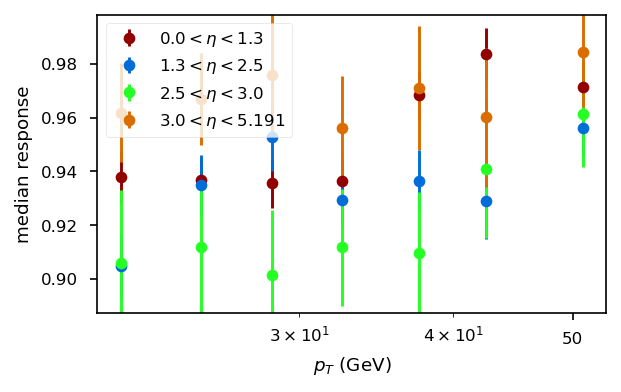

-------------------------
-------------------------
Fitting subsample:  c
Response fits won't be saved
N converge =  112 N_not_converge =  0


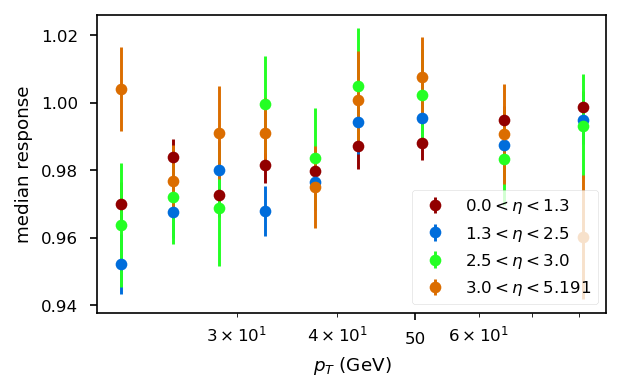

-------------------------
-------------------------
Fitting subsample:  u
Response fits won't be saved
N converge =  112 N_not_converge =  0


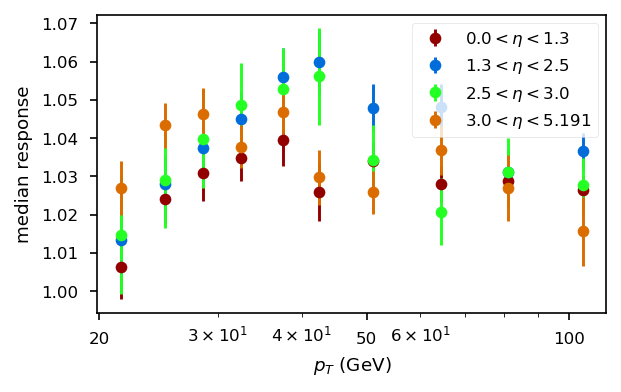

-------------------------
-------------------------
Fitting subsample:  d
Response fits won't be saved
N converge =  112 N_not_converge =  0


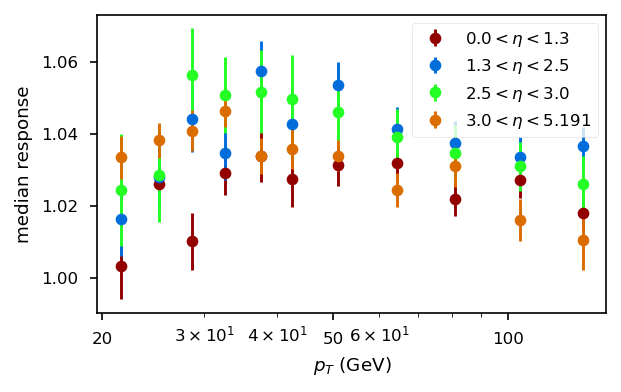

-------------------------
-------------------------
Fitting subsample:  s
Response fits won't be saved
N converge =  112 N_not_converge =  0


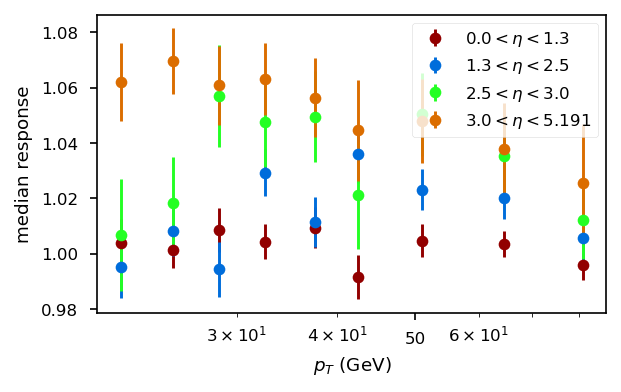

-------------------------
-------------------------
Fitting subsample:  g
Response fits won't be saved
N converge =  112 N_not_converge =  0


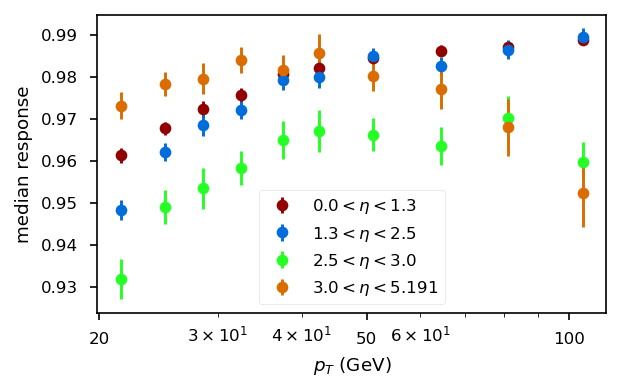

-------------------------
-------------------------
Fitting subsample:  q
Response fits won't be saved
N converge =  112 N_not_converge =  0


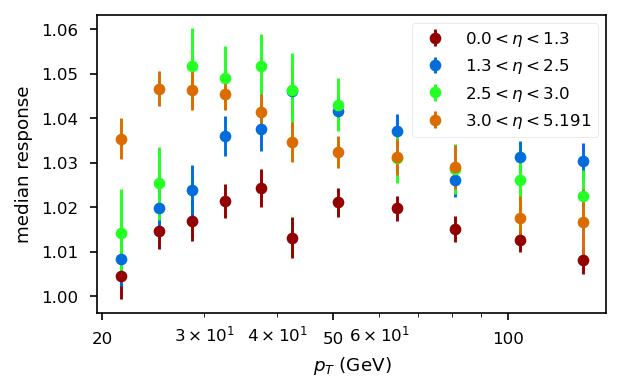

-------------------------
-------------------------
Fitting subsample:  ud
Response fits won't be saved
N converge =  112 N_not_converge =  0


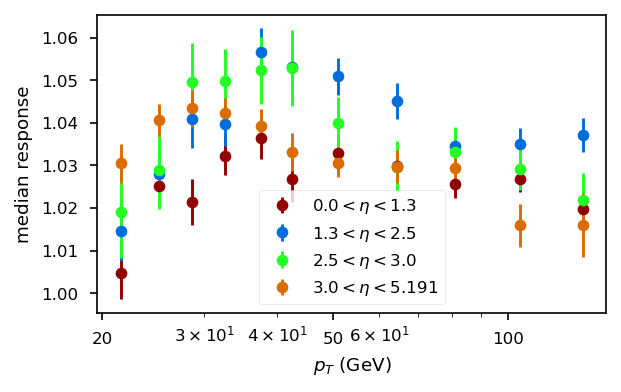

-------------------------
-------------------------
Fitting subsample:  all
Response fits won't be saved
N converge =  112 N_not_converge =  0


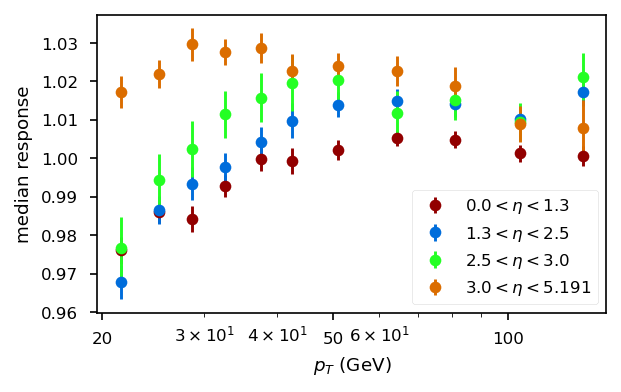

-------------------------
-------------------------
Fitting subsample:  untagged
Response fits won't be saved
N converge =  112 N_not_converge =  0


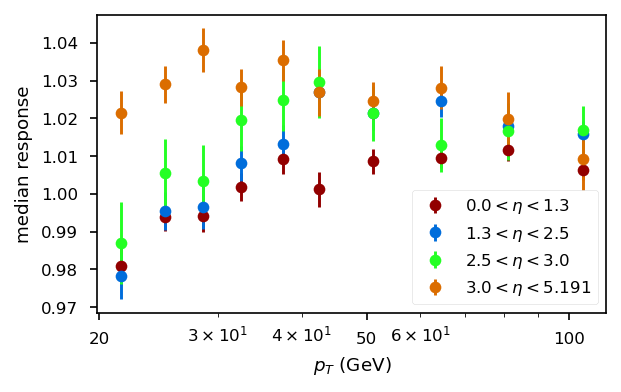

In [209]:
# %%time
# load_fit_res=False
combine_antiflavour = True
# subsamples = ['', '_b', '_c', '_u', '_d', '_s', '_g', '_bbar', '_cbar', '_ubar', '_dbar','_sbar']
# subsamples = ['b', 'c', 'u', 'd', 's', 'g', 'bbar', 'cbar', 'ubar', 'dbar','sbar', 'q', 'qbar', 'ud', 'udbar']
subsamples = ['b', 'c', 'u', 'd', 's', 'g', 'q', 'ud', 'all', 'untagged']
# subsamples = ['all', 'b', 'bbar', 'untagged', 'q', 'ud', 'q', 'ud']
# subsamples = ['b']
# subsamples = ['untagged']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        samp = "_"+samp
        result = {}
        keys = ["Median", "MedianVar", "Median", "MedianStd", "MeanRecoPt"] 
        for key in keys:
            result[key] = read_data(key, samp)
    
    else:
        result = fit_responses(output, samp)
        samp = "_"+samp
        medians.append(result["Median"][0][0])
        medianstds.append(result["MedianStd"][0][0])
        for key in result:
            save_data(result[key], key, samp)
            pass
            
    median = result["Median"]
    medianStd = result["MedianStd"]
    
    meanstd = np.sqrt(result["MeanVar"])
            
    if fine_etabins or one_bin:
        plot_corrections_eta(result["Median"], result["MedianStd"], samp)
    else:
        plot_corrections(result["Median"], result["MedianStd"], samp)

In [211]:
print('-----'*10)
print("All done. Congrats!")

--------------------------------------------------
All done. Congrats!
